In [1]:
%matplotlib inline

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from __future__ import print_function, division
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.sql import SparkSession

from numpy import array
from math import sqrt

spark = SparkSession.builder.master("local[2]") \
   .appName("test") \
   .enableHiveSupport() \
   .getOrCreate()

sc = spark.sparkContext

In [4]:
!head ../data/kmeans_data.txt

5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa
4.9,3.1,1.5,0.1,Iris-setosa


In [5]:
# Load and parse the data
data = sc.textFile("../data/kmeans_data.txt")
parsedData = data.map(lambda line: line.split(',')[:4]).map(lambda line: array([float(x) for x in line]))



In [6]:
parsedData.take(5)

[array([ 5.1,  3.5,  1.4,  0.2]),
 array([ 4.9,  3. ,  1.4,  0.2]),
 array([ 4.7,  3.2,  1.3,  0.2]),
 array([ 4.6,  3.1,  1.5,  0.2]),
 array([ 5. ,  3.6,  1.4,  0.2])]

In [29]:
# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 5, maxIterations=20, initializationMode="random")



In [30]:
clusters.centers

[array([ 5.508,  2.6  ,  3.908,  1.204]),
 array([ 6.52916667,  3.05833333,  5.50833333,  2.1625    ]),
 array([ 6.20769231,  2.85384615,  4.74615385,  1.56410256]),
 array([ 7.475,  3.125,  6.3  ,  2.05 ]),
 array([ 5.006,  3.418,  1.464,  0.244])]

In [31]:
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))


Within Set Sum of Squared Error = 76.56917992705789


In [32]:
WSSSE_list = []

for k in range(2, 20):
    clusters = KMeans.train(parsedData, k, maxIterations=10, initializationMode="random")
    WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    WSSSE_list.append((WSSSE))
    

In [33]:
WSSSE_list

[128.40419523672944,
 97.32592423430009,
 90.63534388533023,
 78.18393188619865,
 73.36159136975371,
 73.676061233186,
 68.93965128587567,
 62.874685040076365,
 61.15983453840698,
 57.21617378743616,
 55.451733555562335,
 53.06866233928649,
 53.38041273657342,
 51.957442774356906,
 50.977500177760476,
 49.13414393610549,
 50.2138559413645,
 52.251615653097005]

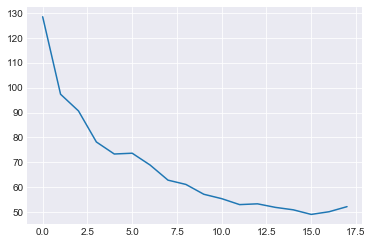

In [34]:
sns.set_style("darkgrid")
plt.plot(WSSSE_list)
plt.show()

In [35]:
spark.stop()